In [3]:
import pandas as pd
import os
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from pathlib import Path
import torch.nn.functional as F
import sys
from sklearn.metrics import accuracy_score, recall_score
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score

In [4]:
import os
import numpy as np
import requests

# Download the required files.

def download_file(url, save_path):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful.
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {save_path}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {url}: {e}")


In [6]:
class LandscapesDataset(Dataset):
    def __init__(self, data_frame, transform=None):
        self.data_frame = data_frame
        self.transform = transform
        self.label = self.data_frame['type']

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        image_path = f"{self.data_frame.iloc[idx, 0]}.jpg"
        try:
            image = Image.open(image_path).convert('RGB')  
        except (IOError, SyntaxError) as e:
            print(f"Error opening image at {image_path}, skipping to next.")
            return self.__getitem__((idx + 1) % len(self))  
        
        if self.transform:
            image = self.transform(image)
            
        label = int(self.data_frame.iloc[idx, 1])
        return image, torch.tensor(label, dtype=torch.long)

In [39]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
from PIL import Image

# th architecture to use
arch = 'resnet18'

# load the pre-trained weights
model_file = '%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)

model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
model.eval()

--2024-10-14 22:03:28--  http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45506139 (43M) [application/x-tar]
Saving to: ‘resnet18_places365.pth.tar’

     0K .......... .......... .......... .......... ..........  0%  261K 2m50s
    50K .......... .......... .......... .......... ..........  0%  524K 2m7s
   100K .......... .......... .......... .......... ..........  0% 15.9M 86s
   150K .......... .......... .......... .......... ..........  0% 74.3M 64s
   200K .......... .......... .......... .......... ..........  0%  531K 68s
   250K .......... .......... .......... .......... ..........  0% 27.7M 57s
   300K .......... .......... .......... .......... ..........  0% 62.5M 49s
   350K .......... .......... .......... .......... ..........

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Processing images:   0%|                                 | 0/20 [00:00<?, ?it/s]

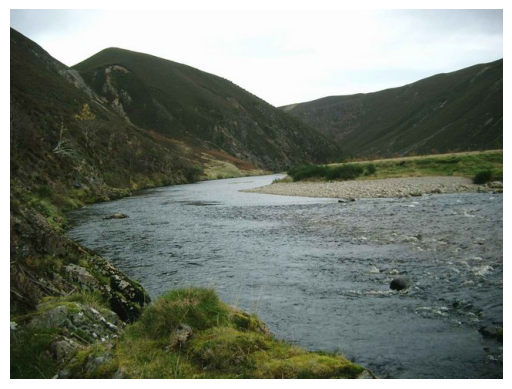

Processing images:   5%|█▎                       | 1/20 [00:00<00:13,  1.37it/s]

resnet18 prediction on photos/27/47/274708_26f767bb.jpg
0.114 -> beach
0.083 -> lagoon
0.072 -> marsh
0.065 -> tundra
0.060 -> lake/natural


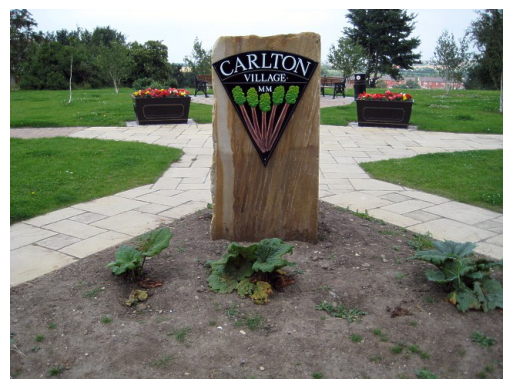

Processing images:  10%|██▌                      | 2/20 [00:01<00:12,  1.44it/s]

resnet18 prediction on photos/90/15/901580_2da4424e.jpg
0.219 -> pond
0.194 -> marsh
0.076 -> lake/natural
0.051 -> beach
0.045 -> swamp


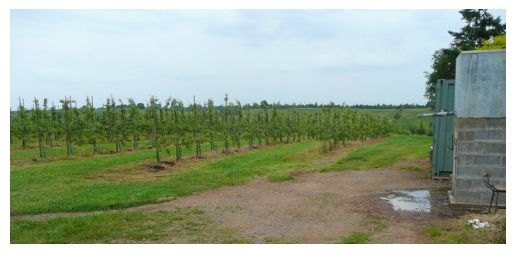

Processing images:  15%|███▊                     | 3/20 [00:01<00:10,  1.63it/s]

resnet18 prediction on photos/86/05/860550_c599fcdb.jpg
0.368 -> watering_hole
0.061 -> field/cultivated
0.050 -> pasture
0.035 -> marsh
0.031 -> beach


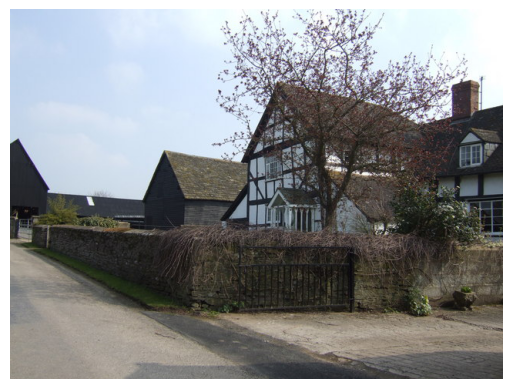

Processing images:  20%|█████                    | 4/20 [00:02<00:09,  1.77it/s]

resnet18 prediction on photos/48/64/486494_2a8d350d.jpg
0.279 -> nursery
0.209 -> windmill
0.035 -> childs_room
0.032 -> oast_house
0.027 -> playroom


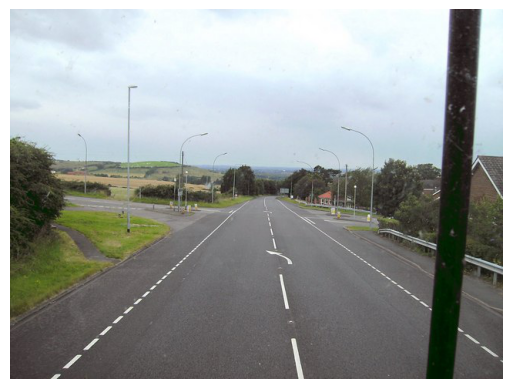

Processing images:  25%|██████▎                  | 5/20 [00:03<00:08,  1.74it/s]

resnet18 prediction on photos/54/24/542458_3597039e.jpg
0.845 -> highway
0.035 -> field/wild
0.033 -> desert/sand
0.011 -> residential_neighborhood
0.011 -> runway


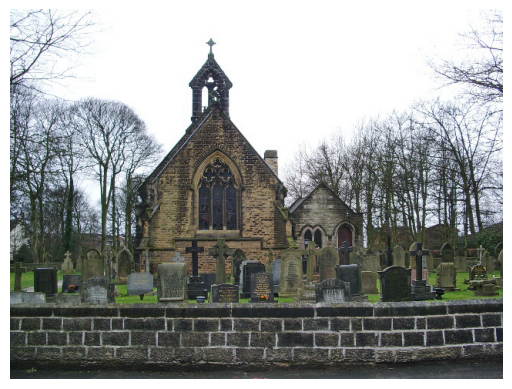

Processing images:  30%|███████▌                 | 6/20 [00:03<00:08,  1.65it/s]

resnet18 prediction on photos/70/26/702616_cc5a0bc3.jpg
0.080 -> cemetery
0.072 -> oast_house
0.070 -> tower
0.060 -> mosque/outdoor
0.038 -> schoolhouse


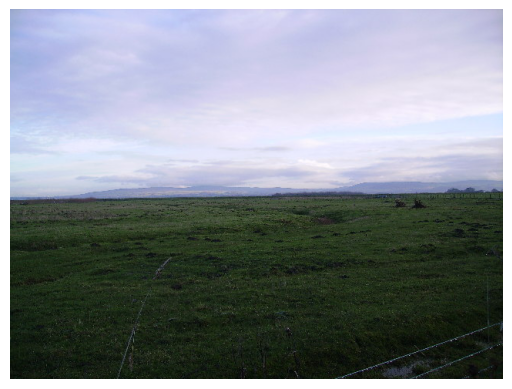

Processing images:  35%|████████▊                | 7/20 [00:04<00:08,  1.58it/s]

resnet18 prediction on photos/10/51/105173_14233f9d.jpg
0.310 -> beach
0.140 -> desert/vegetation
0.095 -> ice_shelf
0.036 -> ocean
0.032 -> marsh


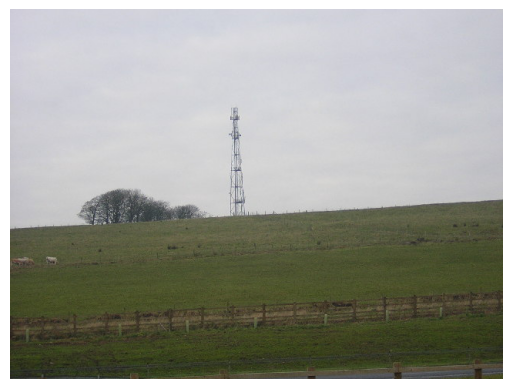

Processing images:  40%|██████████               | 8/20 [00:04<00:07,  1.61it/s]

resnet18 prediction on photos/08/15/081537_c523ba7c.jpg
0.411 -> oilrig
0.156 -> water_tower
0.129 -> tower
0.062 -> windmill
0.052 -> wind_farm


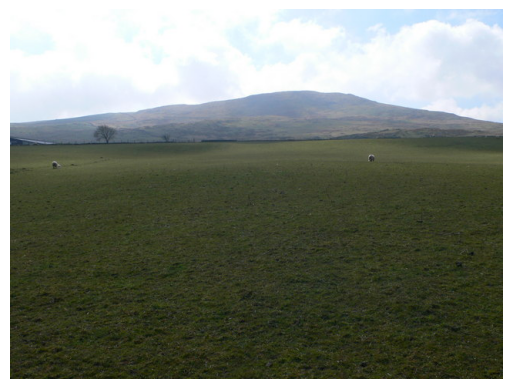

Processing images:  45%|███████████▎             | 9/20 [00:05<00:06,  1.67it/s]

resnet18 prediction on photos/76/84/768446_1f29c1ab.jpg
0.242 -> beach
0.216 -> desert/vegetation
0.048 -> ocean
0.043 -> sky
0.030 -> valley


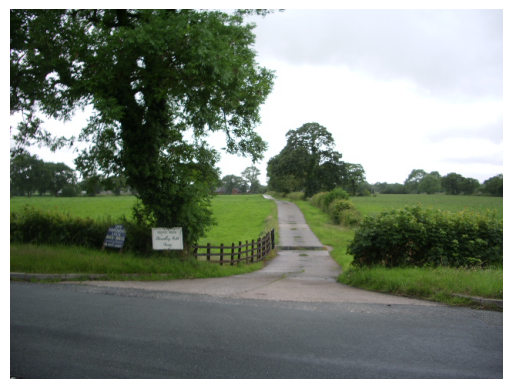

Processing images:  50%|████████████            | 10/20 [00:06<00:06,  1.45it/s]

resnet18 prediction on photos/48/53/485336_d076789e.jpg
0.098 -> nursery
0.092 -> moat/water
0.068 -> pond
0.066 -> hot_spring
0.060 -> canal/natural


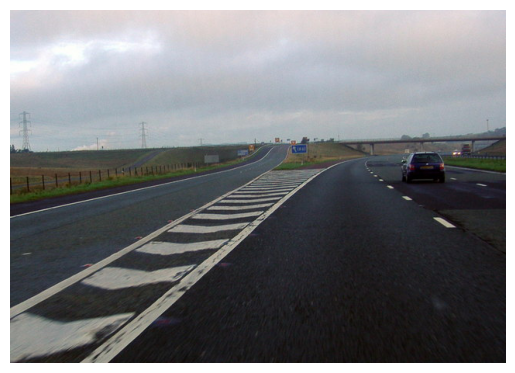

Processing images:  55%|█████████████▏          | 11/20 [00:07<00:06,  1.35it/s]

resnet18 prediction on geophotos/01/08/52/1085276_ade9f34b.jpg
0.231 -> beach
0.107 -> runway
0.101 -> pier
0.095 -> desert/vegetation
0.073 -> promenade


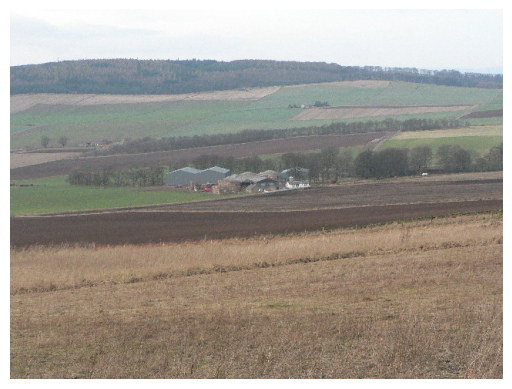

Processing images:  60%|██████████████▍         | 12/20 [00:08<00:06,  1.27it/s]

resnet18 prediction on photos/12/02/120267_d0b57ea9.jpg
0.649 -> field/cultivated
0.065 -> rice_paddy
0.065 -> tundra
0.038 -> farm
0.019 -> corn_field


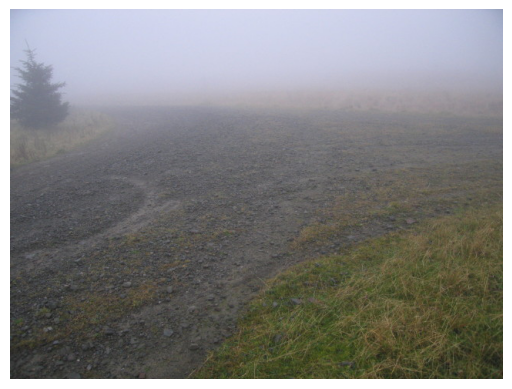

Processing images:  65%|███████████████▌        | 13/20 [00:08<00:05,  1.34it/s]

resnet18 prediction on geophotos/01/03/59/1035975_baf82e0f.jpg
0.393 -> beach
0.096 -> ocean
0.092 -> sky
0.046 -> marsh
0.040 -> coast


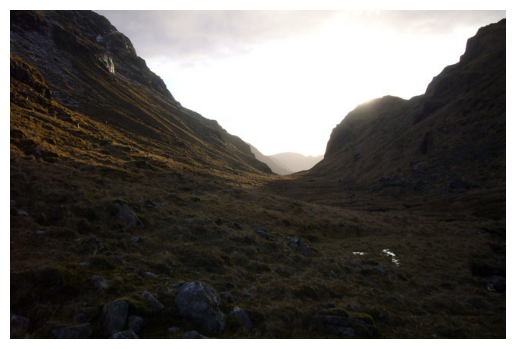

Processing images:  70%|████████████████▊       | 14/20 [00:09<00:04,  1.30it/s]

resnet18 prediction on photos/78/04/780435_41f04136.jpg
0.249 -> desert/vegetation
0.227 -> butte
0.077 -> mountain
0.075 -> cliff
0.060 -> valley


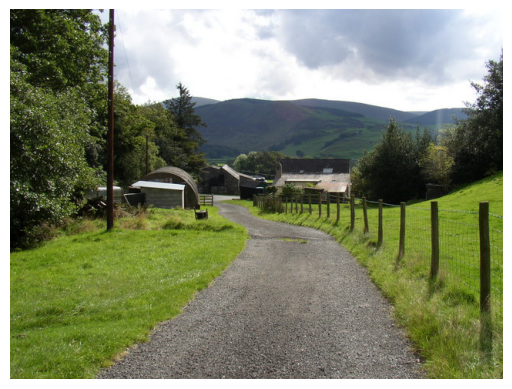

Processing images:  75%|██████████████████      | 15/20 [00:10<00:03,  1.36it/s]

resnet18 prediction on photos/24/68/246872_5eeffc8f.jpg
0.211 -> nursery
0.055 -> childs_room
0.043 -> playground
0.025 -> hot_spring
0.024 -> swimming_pool/indoor


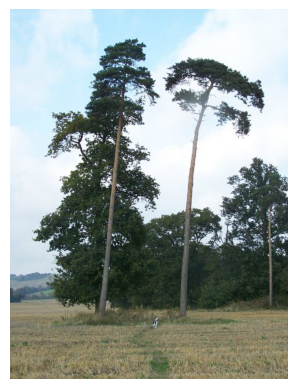

Processing images:  80%|███████████████████▏    | 16/20 [00:11<00:02,  1.36it/s]

resnet18 prediction on geophotos/01/00/62/1006236_23568f3e.jpg
0.217 -> ice_floe
0.091 -> landfill
0.053 -> pond
0.048 -> cemetery
0.036 -> ice_shelf


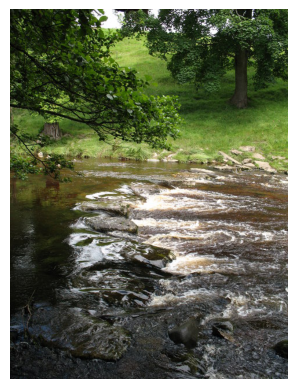

Processing images:  85%|████████████████████▍   | 17/20 [00:11<00:02,  1.47it/s]

resnet18 prediction on photos/88/29/882993_5347b6a0.jpg
0.192 -> hot_spring
0.176 -> watering_hole
0.104 -> tundra
0.059 -> ice_floe
0.053 -> marsh


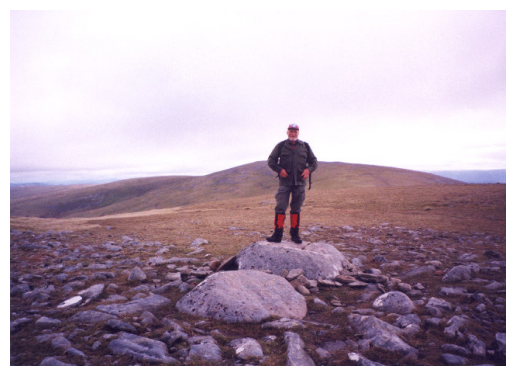

Processing images:  90%|█████████████████████▌  | 18/20 [00:12<00:01,  1.44it/s]

resnet18 prediction on photos/10/05/100567_cf511170.jpg
0.337 -> tundra
0.119 -> badlands
0.111 -> lighthouse
0.097 -> desert/vegetation
0.032 -> butte


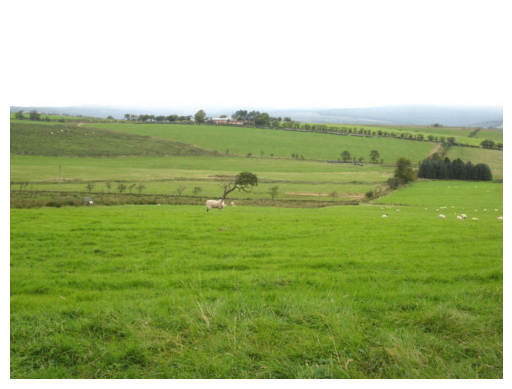

Processing images:  95%|██████████████████████▊ | 19/20 [00:13<00:00,  1.38it/s]

resnet18 prediction on photos/54/82/548246_aabd4ddb.jpg
0.220 -> field/cultivated
0.209 -> hayfield
0.162 -> farm
0.147 -> rice_paddy
0.095 -> pasture


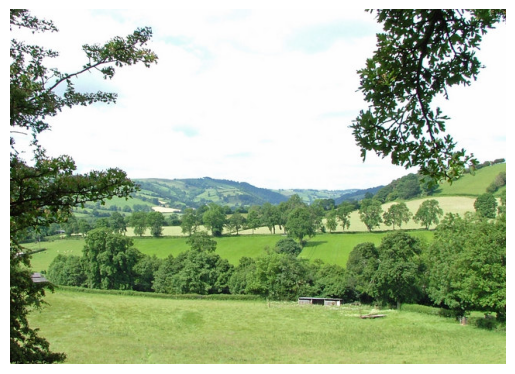

Processing images: 100%|████████████████████████| 20/20 [00:13<00:00,  1.46it/s]

resnet18 prediction on photos/70/57/705746_9200f028.jpg
0.585 -> hayfield
0.028 -> pasture
0.027 -> field/cultivated
0.025 -> village
0.025 -> farm


In [40]:
data_transforms = transforms.Compose([
        # transforms.Resize((256, 256)),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ])

file_name = '/home/ubuntu/landscape-aesthetics/data/external/Places365/categories_places365.txt'
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)

scenic_or_not_paths = project_base_path / 'data' / 'external' / 'scenicornot'

img_data = pd.read_csv(os.path.join(scenic_or_not_paths, 'scenicornot.metadata.csv'), usecols = ['filename'])

sample_data = img_data.sample(n=20, random_state=5)

image_paths = sample_data.iloc[:, 0].tolist()

for img_path in tqdm(image_paths, desc="Processing images"):
    img = Image.open(os.path.join(scenic_or_not_paths, img_path) )
    input_img = V(data_transforms(img).unsqueeze(0))
    plt.imshow(img)
    # forward pass
    logit = model.forward(input_img)
    h_x = F.softmax(logit, 1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    plt.axis('off')
    plt.show()
    print('{} prediction on {}'.format(arch,img_path))
    # output the prediction
    for i in range(0, 5):
        print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))